In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import networkx as nx
import numpy as np
import itertools as it
import random
import time
import scipy
from matplotlib import pyplot as plt
import fresnel
import os
import PIL


# In[ ]:


#define the kinetic constant for simulation
k_Au=-4.0
k_Ag=-5.8
Energy_ratio=0.9
k_on_Au=1.0
k_on_Ag=1.0

E_Au_Au=0.3275
E_Au_Ag=Energy_ratio*E_Au_Au
miu_Au=k_Au*E_Au_Au
miu_Ag=k_Ag*E_Au_Ag
kT=0.0259
beta=1/kT


# In[ ]:


basis=np.array([np.array([0.5,0.5,0]),
                     np.array([-0.5,0.5,0]),
                     np.array([0.5,-0.5,0]),
                     np.array([-0.5,-0.5,0]),
                     np.array([0.5,0,0.5]),
                     np.array([0.5,0,-0.5]),
                     np.array([-0.5,0,0.5]),
                     np.array([-0.5,0,-0.5]),
                     np.array([0,0.5,0.5]),
                     np.array([0,-0.5,0.5]),
                     np.array([0,0.5,-0.5]),
                     np.array([0,-0.5,-0.5]),
                    ])
basis=np.around(basis,7)


# In[ ]:


def coordination_pattern(x,basis,include_center=False):
    """
    To do: obtain the neighbors of an input atom position
    Args:
        x: the position of atoms
        basis: the relative position to the center atom x
    Returns:
        the neighbors of the atoms, excluding the center atoms
    """
    x=np.array(x)
    if include_center==True:
        temp=(x.reshape(-1,1,3)+basis).reshape(-1,3)
        return np.around(np.vstack((x,temp)),7)
    else:
        return np.around((x.reshape(-1,1,3)+basis).reshape(-1,3),7)


# In[ ]:


def addition_event(flag=False):
    
    #addition
    atom_type=random.choices(["Ag","Au"],weights=[k_on_Ag,k_on_Au])[0]
    #sampling strategy 
    site_surface_site_temp=random.choice(site_vacant_list)
    coor_num_Au=site_all.nodes[site_surface_site_temp]["coor_num_Au"]
    coor_num_Ag=site_all.nodes[site_surface_site_temp]["coor_num_Ag"]
    
    #set probability distribution
    if atom_type=="Au":
        fc=len(site_vacant_list)/max((len(site_surface_Au_list)),0.0001)*np.exp(-(beta)*(-miu_Au-E_Au_Au*coor_num_Au))
        accept_probability=1/(1+1/fc)
        flag=np.random.choice([False,True],1,p=[1-accept_probability,accept_probability]).item()
        
    elif atom_type=="Ag":
        fc=len(site_vacant_list)/max((len(site_surface_Ag_list)),0.0001)*np.exp(-(beta)*(-miu_Ag-E_Au_Ag*coor_num_Au))
        accept_probability=1/(1+1/fc)
        flag=np.random.choice([False,True],1,p=[1-accept_probability,accept_probability]).item()
    
    #main part    
    if flag==False:
        pass
    else:
        #deal with the case by adding a Au atom
        if atom_type=="Au":
            #deal with the center atom first
            site_vacant_list.remove(site_surface_site_temp) #remove the site from the vacant list
            site_atoms_Au_list.append(site_surface_site_temp)

            site_all.nodes[site_surface_site_temp]["site"]="Au" #change the vacant site to atom site
            if coor_num_Au+coor_num_Ag!=max_coor_num: #if the this atom is not saturated,add to the surface atom
                site_surface_Au_list.append(site_surface_site_temp)
                
            #deal with the neighbor
            coor_sites=coordination_pattern(site_surface_site_temp,basis,include_center=False)
            for coor_site in coor_sites:
                coor_site=tuple(coor_site)
                # if this neighbor dosen't exist in the overall site, it's a vacant site and should be added
                if site_all.has_node(coor_site)==False:
                    site_vacant_list.append(coor_site)
                    site_all.add_node(coor_site)
                    site_all.nodes[coor_site]["coor_num_Au"]=1
                    site_all.nodes[coor_site]["coor_num_Ag"]=0
                    site_all.nodes[coor_site]["site"]="vacant"
                # if this neighbor exists in the overall site, the coordination number is increased by 1.
                # then if it's atom site and saturated, we should delete it from surface atom
                else:
                    site_all.nodes[coor_site]["coor_num_Au"]=site_all.nodes[coor_site]["coor_num_Au"]+1
                    if site_all.nodes[coor_site]["coor_num_Au"]+site_all.nodes[coor_site]["coor_num_Ag"]==max_coor_num and (site_all.nodes[coor_site]["site"]!="vacant"):
                        if site_all.nodes[coor_site]["site"]=="Au":
                            site_surface_Au_list.remove(coor_site)
                        else:
                            site_surface_Ag_list.remove(coor_site)
                            
        #deal with the case by adding a Ag atom
        else:
            #deal with the center atom first
            site_vacant_list.remove(site_surface_site_temp) #remove the site from the vacant list
            site_atoms_Ag_list.append(site_surface_site_temp)

            site_all.nodes[site_surface_site_temp]["site"]="Ag" #change the vacant site to atom site
            
            if coor_num_Au+coor_num_Ag!=max_coor_num: #if the this atom is not saturated,add to the surface atom
                site_surface_Ag_list.append(site_surface_site_temp)
            #deal with the neighbor
            coor_sites=coordination_pattern(site_surface_site_temp,basis,include_center=False)
            for coor_site in coor_sites:
                coor_site=tuple(coor_site)
                # if this neighbor dosen't exist in the overall site, it's a vacant site and should be added
                if site_all.has_node(coor_site)==False:
                    site_vacant_list.append(coor_site)
                    site_all.add_node(coor_site)
                    site_all.nodes[coor_site]["coor_num_Ag"]=1
                    site_all.nodes[coor_site]["coor_num_Au"]=0
                    site_all.nodes[coor_site]["site"]="vacant"
                # if this neighbor exists in the overall site, the coordination number is increased by 1.
                # then if it's atom site and saturated, we should delete it from surface atom
                else:
                    site_all.nodes[coor_site]["coor_num_Ag"]=site_all.nodes[coor_site]["coor_num_Ag"]+1
                    if site_all.nodes[coor_site]["coor_num_Au"]+site_all.nodes[coor_site]["coor_num_Ag"]==max_coor_num and (site_all.nodes[coor_site]["site"]!="vacant"):
                        if site_all.nodes[coor_site]["site"]=="Au":
                            site_surface_Au_list.remove(coor_site)
                        else:
                            site_surface_Ag_list.remove(coor_site)
    return flag


# In[ ]:


def deletion_event(flag=False):
    #deletion
    if len(site_surface_Ag_list)>0 and len(site_surface_Au_list)>0:
        atom_type=random.choices(["Ag","Au"],weights=[k_on_Ag,k_on_Au])[0]
    elif len(site_surface_Ag_list)>0:
        atom_type="Ag"
    elif len(site_surface_Au_list)>0:
        atom_type="Au"
    
    if atom_type=="Au":
        site_surface_site_temp=random.choice(site_surface_Au_list)
    elif atom_type=="Ag":
        site_surface_site_temp=random.choice(site_surface_Ag_list)
        
    coor_num_Au=site_all.nodes[site_surface_site_temp]["coor_num_Au"]
    coor_num_Ag=site_all.nodes[site_surface_site_temp]["coor_num_Ag"]
    
    if atom_type=="Au":
        #set probability distribution
        fc=len(site_surface_Au_list)/len(site_vacant_list)*np.exp(-(beta)*(miu_Au+E_Au_Au*coor_num_Au))
        accept_probability=1/(1+1/fc)
        flag=np.random.choice([False,True],1,p=[1-accept_probability,accept_probability]).item()
        
    elif atom_type=="Ag":
        #set probability distribution
        fc=len(site_surface_Ag_list)/len(site_vacant_list)*np.exp(-(beta)*(miu_Ag+E_Au_Ag*coor_num_Au))
        accept_probability=1/(1+1/fc)
        flag=np.random.choice([False,True],1,p=[1-accept_probability,accept_probability]).item()

    #main part
    if flag==False:
        pass
    else:
        if atom_type=="Au":
            #deal with the center atom first
            site_surface_Au_list.remove(site_surface_site_temp) #remove the site from the surface list
            site_atoms_Au_list.remove(site_surface_site_temp)
            site_all.nodes[site_surface_site_temp]["site"]="vacant" #change the surface site to vacant site
            if coor_num_Au+coor_num_Ag!=0: #if this vacant site is attached to any atoms
                site_vacant_list.append(site_surface_site_temp)
            else:
                site_all.remove_node(site_surface_site_temp)
            #deal with the neighbor
            coor_sites=coordination_pattern(site_surface_site_temp,basis,include_center=False)
            for coor_site in coor_sites:
                coor_site=tuple(coor_site)
                # if this neighbor dosen't exist in the overall site, it's a mistake
                if site_all.has_node(coor_site)==False:
                    print("Error!")
                # by deleting the atom, the coordination numbers of the neighbors are all decreased by 1
                else:
                    site_all.nodes[coor_site]["coor_num_Au"]=site_all.nodes[coor_site]["coor_num_Au"]-1
                    # if the coordination number is decrease to 0, meaning a detachment happended, if the site is vacant, it's removed
                    if site_all.nodes[coor_site]["coor_num_Au"]+site_all.nodes[coor_site]["coor_num_Ag"]==0 and site_all.nodes[coor_site]["site"]=="vacant":
                        site_all.remove_node(coor_site)
                        site_vacant_list.remove(coor_site)
                    # it will also make the transform from body atom to surface atom
                    elif site_all.nodes[coor_site]["coor_num_Au"]+site_all.nodes[coor_site]["coor_num_Ag"]==max_coor_num-1 and site_all.nodes[coor_site]["site"]!="vacant":
                        if site_all.nodes[coor_site]["site"]=="Au":
                            site_surface_Au_list.append(coor_site)
                        elif site_all.nodes[coor_site]["site"]=="Ag":
                            site_surface_Ag_list.append(coor_site)   
        else:
            #deal with the center atom first
            site_surface_Ag_list.remove(site_surface_site_temp) #remove the site from the surface list
            site_atoms_Ag_list.remove(site_surface_site_temp)
            site_all.nodes[site_surface_site_temp]["site"]="vacant" #change the surface site to vacant site
            if coor_num_Au+coor_num_Ag!=0: #if this vacant site is attached to any atoms
                site_vacant_list.append(site_surface_site_temp)
            else:
                site_all.remove_node(site_surface_site_temp)
            #deal with the neighbor
            coor_sites=coordination_pattern(site_surface_site_temp,basis,include_center=False)
            
            for coor_site in coor_sites:
                coor_site=tuple(coor_site)
                # if this neighbor dosen't exist in the overall site, it's a mistake
                if site_all.has_node(coor_site)==False:
                    print("Error!")
                # by deleting the atom, the coordination numbers of the neighbors are all decreased by 1
                else:
                    site_all.nodes[coor_site]["coor_num_Ag"]=site_all.nodes[coor_site]["coor_num_Ag"]-1
                    # if the coordination number is decrease to 0, meaning a detachment happended, if the site is vacant, it's removed
                    if site_all.nodes[coor_site]["coor_num_Au"]+site_all.nodes[coor_site]["coor_num_Ag"]==0 and site_all.nodes[coor_site]["site"]=="vacant":
                        site_all.remove_node(coor_site)
                        site_vacant_list.remove(coor_site)
                    # it will also make the transform from body atom to surface atom
                    elif site_all.nodes[coor_site]["coor_num_Au"]+site_all.nodes[coor_site]["coor_num_Ag"]==max_coor_num-1 and site_all.nodes[coor_site]["site"]!="vacant":
                        if site_all.nodes[coor_site]["site"]=="Au":
                            site_surface_Au_list.append(coor_site)
                        elif site_all.nodes[coor_site]["site"]=="Ag":
                            site_surface_Ag_list.append(coor_site)
    return flag


# In[ ]:


def replacement_event(flag=False):
    #replacement
    #sampling strategy
    if len(site_surface_Ag_list)>0 and len(site_surface_Au_list)>0:
        atom_type=random.choices(["Au","Ag"],weights=[k_on_Ag,k_on_Au])[0]
    elif len(site_surface_Ag_list)>0:
        atom_type="Ag"
    elif len(site_surface_Au_list)>0:
        atom_type="Au"
    
    if atom_type=="Au":
        site_temp=random.choice(site_surface_Au_list)
    elif atom_type=="Ag":
        site_temp=random.choice(site_surface_Ag_list)
        
    coor_num_Au=site_all.nodes[site_temp]["coor_num_Au"]
    coor_num_Ag=site_all.nodes[site_temp]["coor_num_Ag"]
    
    if atom_type=="Au":
        #set probability distribution
        fc=len(site_surface_Au_list)/max(len(site_surface_Ag_list),0.0001)*np.exp(-(beta)*(miu_Au-miu_Ag+(E_Au_Au-E_Au_Ag)*coor_num_Au))
        accept_probability=1/(1+1/fc)
        flag=np.random.choice([False,True],1,p=[1-accept_probability,accept_probability]).item()
        
    elif atom_type=="Ag":
        #set probability distribution
        fc=len(site_surface_Ag_list)/max(len(site_surface_Au_list),0.0001)*np.exp(-(beta)*(miu_Ag-miu_Au+(E_Au_Ag-E_Au_Au)*coor_num_Au))
        accept_probability=1/(1+1/fc)
        flag=np.random.choice([False,True],1,p=[1-accept_probability,accept_probability]).item()
        
    
    #Main change part
    if flag==False:
        pass
    
    else:
        if atom_type=="Au":
            #deal with the center cell first
            #update list
            site_atoms_Au_list.remove(site_temp)
            site_atoms_Ag_list.append(site_temp)
            if coor_num_Au+coor_num_Ag<max_coor_num:
                site_surface_Au_list.remove(site_temp)
                site_surface_Ag_list.append(site_temp) 
            #update graph
            site_all.nodes[site_temp]["site"]="Ag"
            #deal with the neighbor
            coor_sites=coordination_pattern(site_temp,basis,include_center=False)
            for coor_site in coor_sites:
                coor_site=tuple(coor_site)
                # if this neighbor exists in the overall site, 
                #the coordination number of this site is changed because of replacement
                site_all.nodes[coor_site]["coor_num_Ag"]=site_all.nodes[coor_site]["coor_num_Ag"]+1
                site_all.nodes[coor_site]["coor_num_Au"]=site_all.nodes[coor_site]["coor_num_Au"]-1
        else:
            #deal with the center cell first
            #update list
            site_atoms_Ag_list.remove(site_temp)
            site_atoms_Au_list.append(site_temp)
            if coor_num_Au+coor_num_Ag<max_coor_num:
                site_surface_Ag_list.remove(site_temp)
                site_surface_Au_list.append(site_temp) 
            #update graph
            site_all.nodes[site_temp]["site"]="Au"
            #deal with the neighbor
            coor_sites=coordination_pattern(site_temp,basis,include_center=False)
            for coor_site in coor_sites:
                coor_site=tuple(coor_site)
                # if this neighbor exists in the overall site, 
                #the coordination number of this site is changed because of replacement
                site_all.nodes[coor_site]["coor_num_Au"]=site_all.nodes[coor_site]["coor_num_Au"]+1
                site_all.nodes[coor_site]["coor_num_Ag"]=site_all.nodes[coor_site]["coor_num_Ag"]-1
    
    return flag


# In[ ]:
cpu_limit = fresnel.Device(mode='cpu', n=5)

site_all=nx.Graph()
site_vacant=nx.Graph()
site_surface_Au=nx.Graph()
site_atoms_Au=nx.Graph()

max_coor_num=12
positino=np.loadtxt("/home/yibin/workspace/Monte_Carlo_Simulation/Growth_with_silverV2/atomList_TruncatedOctahedron.csv",delimiter=",")
                
#create the initial shape of a truncated_octahedron
for i in positino:
    #if some criteria is satisfied
    site_all.add_node(tuple(i))
    
site_atoms_Au.add_nodes_from(site_all)
site_atoms_Au_list=list(site_atoms_Au)
site_atoms_Ag_list=[]

#calculate the initial surface atoms, vacant sites and corresponding coordination numbers
#for all the atoms
for site_all_list_temp in site_atoms_Au_list:
    #obtain the coordinated atoms to that specific atom
    coor=coordination_pattern(np.asarray(site_all_list_temp),basis)
    #begin to count how many atoms already exsting in the site list
    coor_num=0
    for coor_temp in coor:
        coor_temp=tuple(coor_temp)
        if site_atoms_Au.has_node(coor_temp):
            coor_num=coor_num+1
        else:
            # if not exist, it's a vacant site, so we add it to the overall site and vacant site graph
            if site_vacant.has_node(coor_temp):
                site_all.nodes[coor_temp]["coor_num_Au"]=site_all.nodes[coor_temp]["coor_num_Au"]+1
            else:
                site_all.add_node(tuple(coor_temp))
                site_vacant.add_node(tuple(coor_temp))
                site_all.nodes[coor_temp]["coor_num_Au"]=1
                site_all.nodes[coor_temp]["coor_num_Ag"]=0
                site_all.nodes[coor_temp]["site"]="vacant"

    #record the coordination of that specific atom        
    site_all.nodes[site_all_list_temp]["coor_num_Au"]=coor_num
    site_all.nodes[site_all_list_temp]["coor_num_Ag"]=0
    site_all.nodes[site_all_list_temp]["site"]="Au"

    #if the coordination number is not saturated, it's a surface atom and add to the surface atom graph
    if coor_num<max_coor_num:
        site_surface_Au.add_node(site_all_list_temp)

site_surface_Au_list=list(site_surface_Au)
site_surface_Ag_list=[]
site_vacant_list=list(site_vacant)

path="/mnt/orkney/Chemobot/Nanobot-Monte_Carlo_Simulation/Au_Ag_5/example_{}_{}_{}_{}_{}/".format(k_Au,k_Ag,Energy_ratio,k_on_Ag,k_on_Au)

if os.path.isdir(path)==False:
    os.mkdir(path)
    os.mkdir(path+"structure")
    os.mkdir(path+"plot")

In [2]:
# In[ ]:
#plot the seeds
data=np.array(site_atoms_Au_list+site_atoms_Ag_list)

scene = fresnel.Scene(device=cpu_limit)
geometry1 = fresnel.geometry.Sphere(scene, N=len(data), radius=np.sqrt(2)/4)
geometry1.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]),
                                              roughness=0.8)

geometry1.position[:] = data
geometry1.material.primitive_color_mix = 1.0

geometry1.color[0:len(site_atoms_Au_list)]=fresnel.color.linear([1,1,0])
geometry1.color[len(site_atoms_Au_list):len(data)]=fresnel.color.linear([0.25,0.5,0.9])

out=fresnel.preview(scene)
image = PIL.Image.fromarray(out[:], mode='RGBA')
image.save(path+"plot/"+"seed.png")

In [3]:
def obtain_coor_number_for_atoms(atom_list,site_all):
    if len(atom_list)>0:
        atom_list_all_data=np.hstack((np.array(atom_list),
                                    np.array([site_all.nodes[coor_site]["coor_num_Au"] for coor_site in atom_list]).reshape(-1,1),
                                    np.array([site_all.nodes[coor_site]["coor_num_Ag"] for coor_site in atom_list]).reshape(-1,1)))
    else:
        atom_list_all_data=[]
    return atom_list_all_data

In [4]:
# In[ ]:
size_original=len(site_surface_Au_list)+len(site_surface_Ag_list)
geometry=[]
len1=size_original

count=0
for count in range(2000000):
    event_index=np.random.choice([0,1,2],1).item()
    if event_index==0:
        flag=addition_event()
    elif event_index==1:
        flag=replacement_event()
    elif event_index==2:
        flag=deletion_event()
        
    if count%40000==0:
        
        Au_data=obtain_coor_number_for_atoms(site_atoms_Au_list,site_all)
        Ag_data=obtain_coor_number_for_atoms(site_atoms_Ag_list,site_all)
        
        np.savetxt(path+"structure/"+"Au_data_%d.csv"%count,Au_data,delimiter=",")
        np.savetxt(path+"structure/"+"Ag_data_%d.csv"%count,Ag_data,delimiter=",")
        
    if count%100000==0:
        data=np.array(site_atoms_Au_list+site_atoms_Ag_list)
        scene = fresnel.Scene(device=cpu_limit)
        geometry1 = fresnel.geometry.Sphere(scene, N=len(data), radius=np.sqrt(2)/4)
        geometry1.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]),
                                                      roughness=0.8)
        geometry1.position[:] = data
        geometry1.material.primitive_color_mix = 1.0

        geometry1.color[0:len(site_atoms_Au_list)]=fresnel.color.linear([1,1,0])
        geometry1.color[len(site_atoms_Au_list):len(data)]=fresnel.color.linear([0.25,0.5,0.9])

        out=fresnel.preview(scene)
        image = PIL.Image.fromarray(out[:], mode='RGBA')
        image.save(path+"plot/"+"%d.png"%count)

In [4]:
Au_surface_ratio=[]
Ag_surface_ratio=[]
Au_bulk_ratio=[]
Ag_bulk_ratio=[]
L_total=[]
L_surface=[]
Au_surface_coor_num_data=[]
Ag_surface_coor_num_data=[]

for count in range(2000000):
    if count%40000==0:
        #read in data
        Au_data=np.loadtxt(path+"structure/"+"Au_data_%d.csv"%count,delimiter=",").reshape(-1,5)
        Ag_data=np.loadtxt(path+"structure/"+"Ag_data_%d.csv"%count,delimiter=",").reshape(-1,5)
        #record the surface Au/Ag number
        L1=((Au_data[:,-1]+Au_data[:,-2])<12).sum()
        L2=((Ag_data[:,-1]+Ag_data[:,-2])<12).sum()
        L_surface.append(L1+L2)
        Au_surface_ratio.append(L1/(L1+L2))
        Ag_surface_ratio.append(L2/(L1+L2))
        Au_surface_coor_num_data.append(Au_data[((Au_data[:,-1]+Au_data[:,-2])<12)][:,3:5])
        Ag_surface_coor_num_data.append(Ag_data[((Ag_data[:,-1]+Ag_data[:,-2])<12)][:,3:5])
        
        #record bulk Au/Ag number
        L1=len(Au_data)
        L2=len(Ag_data)
        L_total.append(L1+L2)
        Au_bulk_ratio.append(L1/(L1+L2))
        Ag_bulk_ratio.append(L2/(L1+L2))

/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: loadtxt: Empty input file: "/mnt/orkney/Chemobot/Nanobot-Monte_Carlo_Simulation/Au_Ag_5/example_-4.0_-5.8_0.9_1.0_1.0/structure/Ag_data_0.csv"
  
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: loadtxt: Empty input file: "/mnt/orkney/Chemobot/Nanobot-Monte_Carlo_Simulation/Au_Ag_5/example_-4.0_-5.8_0.9_1.0_1.0/structure/Ag_data_40000.csv"
  


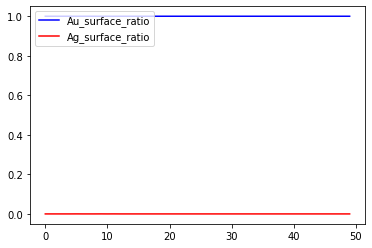

In [5]:
plt.figure()
plt.plot(Au_surface_ratio,"-b",label="Au_surface_ratio",)
plt.plot(Ag_surface_ratio,"-r",label="Ag_surface_ratio")
plt.legend(loc="upper left")
plt.show()

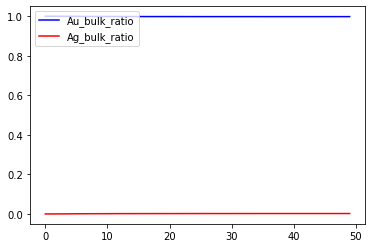

In [6]:
plt.figure()
plt.plot(Au_bulk_ratio,"-b",label="Au_bulk_ratio",)
plt.plot(Ag_bulk_ratio,"-r",label="Ag_bulk_ratio")
plt.legend(loc="upper left")
plt.show()

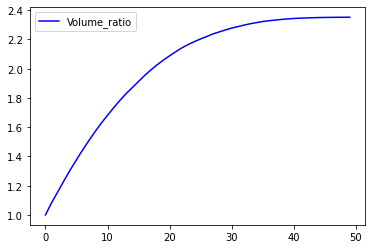

In [7]:
plt.figure()
plt.plot(np.array(L_total)/L_total[0],"-b",label="Volume_ratio",)
plt.legend(loc="upper left")
plt.show()

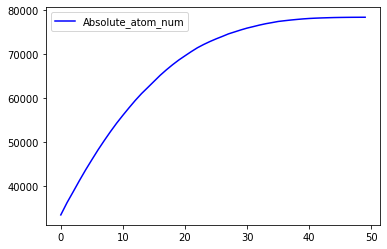

In [8]:
plt.figure()
plt.plot(np.array(L_total),"-b",label="Absolute_atom_num",)
plt.legend(loc="upper left")
plt.show()

In [9]:
Au_coor_num_mean=np.array([i.mean(axis=0) for i in Au_surface_coor_num_data])
Au_coor_num_sigma=np.array([np.std(i,axis=0) for i in Au_surface_coor_num_data])

Ag_coor_num_mean=np.array([i.mean(axis=0) for i in Ag_surface_coor_num_data])
Ag_coor_num_sigma=np.array([np.std(i,axis=0) for i in Ag_surface_coor_num_data])

/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


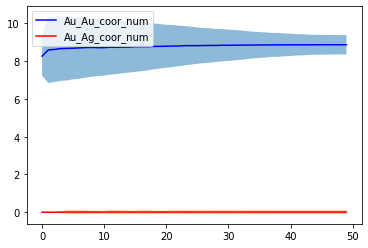

In [10]:
plt.figure()
plt.plot(Au_coor_num_mean[:,0],"-b",label="Au_Au_coor_num")

plt.fill_between(np.arange(len(Au_coor_num_mean)),
                 Au_coor_num_mean[:,0]-Au_coor_num_sigma[:,0],
                 Au_coor_num_mean[:,0]+Au_coor_num_sigma[:,0],
                 alpha=0.5)

plt.plot(Au_coor_num_mean[:,1],"-r",label="Au_Ag_coor_num")
plt.fill_between(np.arange(len(Au_coor_num_mean)),
                 Au_coor_num_mean[:,1]-Au_coor_num_sigma[:,1],
                 Au_coor_num_mean[:,1]+Au_coor_num_sigma[:,1],
                 alpha=0.5)

plt.legend(loc="upper left")
plt.show()

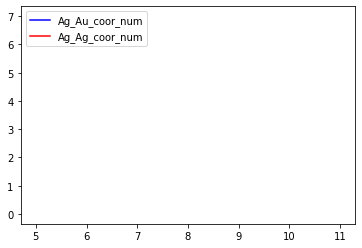

In [11]:
plt.figure()
plt.plot(Ag_coor_num_mean[:,0],"-b",label="Ag_Au_coor_num",)
plt.fill_between(np.arange(len(Ag_coor_num_mean)),
                 Ag_coor_num_mean[:,0]-Ag_coor_num_sigma[:,0],
                 Ag_coor_num_mean[:,0]+Ag_coor_num_sigma[:,0],
                 alpha=0.5)

plt.plot(Ag_coor_num_mean[:,1],"-r",label="Ag_Ag_coor_num")
plt.fill_between(np.arange(len(Ag_coor_num_mean)),
                 Ag_coor_num_mean[:,1]-Ag_coor_num_sigma[:,1],
                 Ag_coor_num_mean[:,1]+Ag_coor_num_sigma[:,1],
                 alpha=0.5)
plt.legend(loc="upper left")
plt.show()

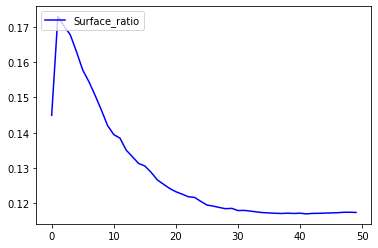

In [12]:
plt.figure()
plt.plot(np.array(L_surface)/np.array(L_total),"-b",label="Surface_ratio",)
plt.legend(loc="upper left")
plt.show()